<a href="https://colab.research.google.com/github/sarvnn/EVA4/blob/master/QuizDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quiz 9


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Dataset and Creating Train/Test Split

In [0]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model - QuizDNN.py


In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # CONVOLUTION BLOCK 1
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # TRANSITION BLOCK 1
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # TRANSITION BLOCK 1
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 14       
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7

        # CONVOLUTION BLOCK 2
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_value)
        ) # output_size = 3
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_value)
        ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.FC = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool2(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.gap(x)        
        x = self.FC(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           4,608
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1

# Training and Testing


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Modifying learning rate



In [0]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.03

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.336051106452942 Batch_id=390 Accuracy=42.34: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3356, Accuracy: 5423/10000 (54.23%)

EPOCH: 2


Loss=1.326995611190796 Batch_id=390 Accuracy=57.61: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9656, Accuracy: 6813/10000 (68.13%)

EPOCH: 3


Loss=0.9010167121887207 Batch_id=390 Accuracy=63.55: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9021, Accuracy: 7089/10000 (70.89%)

EPOCH: 4


Loss=1.0603827238082886 Batch_id=390 Accuracy=67.15: 100%|██████████| 391/391 [00:44<00:00,  8.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8348, Accuracy: 7312/10000 (73.12%)

EPOCH: 5


Loss=0.9491971731185913 Batch_id=390 Accuracy=69.29: 100%|██████████| 391/391 [00:43<00:00,  9.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7506, Accuracy: 7647/10000 (76.47%)

EPOCH: 6


Loss=0.7376183271408081 Batch_id=390 Accuracy=71.10: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7207, Accuracy: 7843/10000 (78.43%)

EPOCH: 7


Loss=0.7714787721633911 Batch_id=390 Accuracy=72.36: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6922, Accuracy: 7934/10000 (79.34%)

EPOCH: 8


Loss=0.8864411115646362 Batch_id=390 Accuracy=73.20: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6619, Accuracy: 7993/10000 (79.93%)

EPOCH: 9


Loss=0.5360747575759888 Batch_id=390 Accuracy=74.33: 100%|██████████| 391/391 [00:42<00:00,  9.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6432, Accuracy: 8032/10000 (80.32%)

EPOCH: 10


Loss=0.9483500719070435 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6210, Accuracy: 8095/10000 (80.95%)

EPOCH: 11


Loss=0.8541814684867859 Batch_id=390 Accuracy=75.48: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5996, Accuracy: 8193/10000 (81.93%)

EPOCH: 12


Loss=0.74219810962677 Batch_id=390 Accuracy=76.60: 100%|██████████| 391/391 [00:44<00:00,  8.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5415, Accuracy: 8364/10000 (83.64%)

EPOCH: 13


Loss=0.8333050608634949 Batch_id=390 Accuracy=77.11: 100%|██████████| 391/391 [00:43<00:00,  9.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5517, Accuracy: 8313/10000 (83.13%)

EPOCH: 14


Loss=0.7208614349365234 Batch_id=390 Accuracy=77.49: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5157, Accuracy: 8461/10000 (84.61%)

EPOCH: 15


Loss=0.4054621756076813 Batch_id=390 Accuracy=78.08: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5202, Accuracy: 8378/10000 (83.78%)

EPOCH: 16


Loss=0.645829439163208 Batch_id=390 Accuracy=78.67: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5299, Accuracy: 8372/10000 (83.72%)

EPOCH: 17


Loss=0.462024986743927 Batch_id=390 Accuracy=78.81: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5231, Accuracy: 8396/10000 (83.96%)

EPOCH: 18


Loss=0.5292067527770996 Batch_id=390 Accuracy=79.33: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4916, Accuracy: 8526/10000 (85.26%)

EPOCH: 19


Loss=0.5370519757270813 Batch_id=390 Accuracy=79.95: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5120, Accuracy: 8476/10000 (84.76%)

EPOCH: 20


Loss=1.018754482269287 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:43<00:00,  9.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5021, Accuracy: 8502/10000 (85.02%)

EPOCH: 21


Loss=0.737517237663269 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4857, Accuracy: 8560/10000 (85.60%)

EPOCH: 22


Loss=0.7023516893386841 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:42<00:00,  9.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4943, Accuracy: 8546/10000 (85.46%)

EPOCH: 23


Loss=0.6368262767791748 Batch_id=390 Accuracy=81.06: 100%|██████████| 391/391 [00:42<00:00,  9.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4899, Accuracy: 8570/10000 (85.70%)

EPOCH: 24


Loss=0.6101332902908325 Batch_id=390 Accuracy=81.48: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5037, Accuracy: 8536/10000 (85.36%)

EPOCH: 25


Loss=0.4862672686576843 Batch_id=390 Accuracy=81.75: 100%|██████████| 391/391 [00:43<00:00,  9.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4858, Accuracy: 8538/10000 (85.38%)

EPOCH: 26


Loss=0.7627466917037964 Batch_id=390 Accuracy=81.74: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4655, Accuracy: 8652/10000 (86.52%)

EPOCH: 27


Loss=0.5619810819625854 Batch_id=390 Accuracy=82.14: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5044, Accuracy: 8513/10000 (85.13%)

EPOCH: 28


Loss=0.6347888112068176 Batch_id=390 Accuracy=82.18: 100%|██████████| 391/391 [00:43<00:00,  9.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4649, Accuracy: 8635/10000 (86.35%)

EPOCH: 29


Loss=0.5511844754219055 Batch_id=390 Accuracy=82.66: 100%|██████████| 391/391 [00:42<00:00,  9.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 8703/10000 (87.03%)

EPOCH: 30


Loss=0.5082579255104065 Batch_id=390 Accuracy=82.89: 100%|██████████| 391/391 [00:43<00:00,  9.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4666, Accuracy: 8636/10000 (86.36%)

EPOCH: 31


Loss=0.8640750646591187 Batch_id=390 Accuracy=82.98: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4517, Accuracy: 8704/10000 (87.04%)

EPOCH: 32


Loss=0.720824658870697 Batch_id=390 Accuracy=83.50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 8628/10000 (86.28%)

EPOCH: 33


Loss=0.6485311985015869 Batch_id=390 Accuracy=83.49: 100%|██████████| 391/391 [00:43<00:00,  9.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4440, Accuracy: 8711/10000 (87.11%)

EPOCH: 34


Loss=0.3966721296310425 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4523, Accuracy: 8706/10000 (87.06%)

EPOCH: 35


Loss=0.36013364791870117 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4618, Accuracy: 8670/10000 (86.70%)

EPOCH: 36


Loss=0.568606972694397 Batch_id=390 Accuracy=84.10: 100%|██████████| 391/391 [00:44<00:00,  8.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4935, Accuracy: 8618/10000 (86.18%)

EPOCH: 37


Loss=0.6450050473213196 Batch_id=390 Accuracy=84.06: 100%|██████████| 391/391 [00:42<00:00,  9.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4927, Accuracy: 8651/10000 (86.51%)

EPOCH: 38


Loss=0.4081707000732422 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [00:42<00:00,  9.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4601, Accuracy: 8726/10000 (87.26%)

EPOCH: 39


Loss=0.4762212336063385 Batch_id=390 Accuracy=84.33: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4539, Accuracy: 8726/10000 (87.26%)

EPOCH: 40


Loss=0.5926081538200378 Batch_id=390 Accuracy=84.75: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s]



Test set: Average loss: 0.4720, Accuracy: 8654/10000 (86.54%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

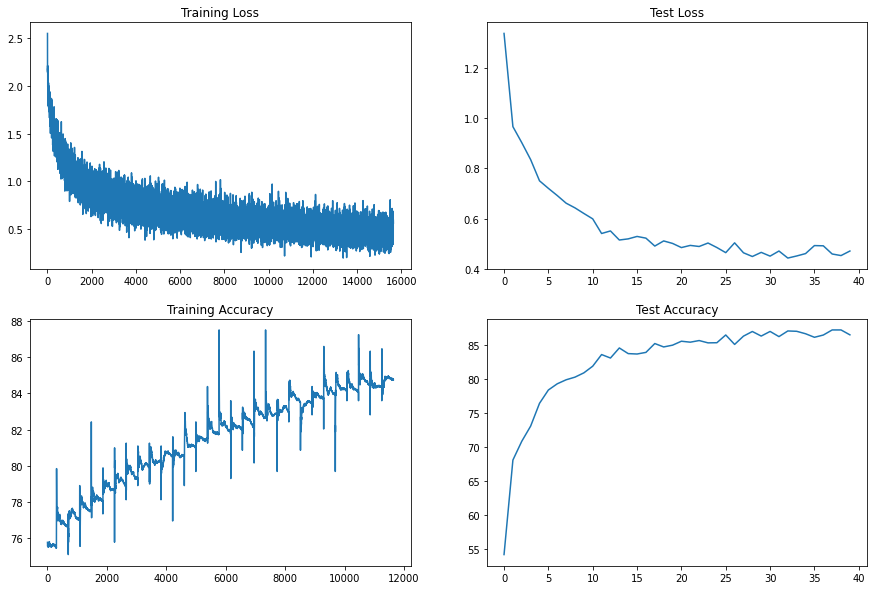

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")